## Part I: Building a Basic Neural Network

### Step 1: Loading the Dataset and Main Statistics

#### Importing required libraries

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

#### Reading Dataset

In [138]:
df = pd.read_csv('datasets/dataset.csv')
print(df.head())

  f1   f2  f3  f4   f5    f6     f7  target
0  6  148  72  35    0  33.6  0.627       1
1  1   85  66  29    0  26.6  0.351       0
2  8  183  64   0    0  23.3  0.672       1
3  1   89  66  23   94  28.1  0.167       0
4  0  137  40  35  168  43.1  2.288       1


#### Analyzing the dataset

In [139]:
# Basic statistics
print(df.describe(include = 'all'))

print("null values: ",df.isnull().sum())

print(df.dtypes)

         f1   f2          f3   f4   f5   f6     f7      target
count   766  766  766.000000  766  766  766    766  766.000000
unique   18  137         NaN   52  186  249    517         NaN
top       1   99         NaN    0    0   32  0.254         NaN
freq    134   17         NaN  226  372   13      6         NaN
mean    NaN  NaN   69.118799  NaN  NaN  NaN    NaN    0.349869
std     NaN  NaN   19.376901  NaN  NaN  NaN    NaN    0.477240
min     NaN  NaN    0.000000  NaN  NaN  NaN    NaN    0.000000
25%     NaN  NaN   62.500000  NaN  NaN  NaN    NaN    0.000000
50%     NaN  NaN   72.000000  NaN  NaN  NaN    NaN    0.000000
75%     NaN  NaN   80.000000  NaN  NaN  NaN    NaN    1.000000
max     NaN  NaN  122.000000  NaN  NaN  NaN    NaN    1.000000
null values:  f1        0
f2        0
f3        0
f4        0
f5        0
f6        0
f7        0
target    0
dtype: int64
f1        object
f2        object
f3         int64
f4        object
f5        object
f6        object
f7        object
ta

#### Handling invalid character entries

In [140]:
# Since all the columns have numerical values and we can see some outliers with characters, we will remove these characters with mode of each column

# f1
print("unique f1 values  ",df['f1'].unique())
df['f1'] = pd.to_numeric(df['f1'], errors='coerce')
mode_value_f1 = df['f1'].mode()[0]
df['f1'] = df['f1'].fillna(mode_value_f1)
print("unique f1 values after removing invalids ",df['f1'].unique())


# f2
df['f2'] = pd.to_numeric(df['f2'], errors='coerce')
mode_value_f2 = df['f2'].mode()[0]
df['f2'] = df['f2'].fillna(mode_value_f2)

# f3
# Already integer column

# f4
df['f4'] = pd.to_numeric(df['f4'], errors='coerce')
mode_value_f4 = df['f4'].mode()[0]
df['f4'] = df['f4'].fillna(mode_value_f4)

# f5
df['f5'] = pd.to_numeric(df['f5'], errors='coerce')
mode_value_f5 = df['f5'].mode()[0]
df['f5'] = df['f5'].fillna(mode_value_f5)

# f6
df['f6'] = pd.to_numeric(df['f6'], errors='coerce')
mode_value_f6 = df['f6'].mode()[0]
df['f6'] = df['f6'].fillna(mode_value_f6)

# f7
df['f7'] = pd.to_numeric(df['f7'], errors='coerce')
mode_value_f7 = df['f7'].mode()[0]
df['f7'] = df['f7'].fillna(mode_value_f7)

unique f1 values   ['6' '1' '8' '0' '5' '3' '10' '2' '4' '7' '9' '11' '13' '15' '17' '12'
 '14' 'c']
unique f1 values after removing invalids  [ 6.  1.  8.  0.  5.  3. 10.  2.  4.  7.  9. 11. 13. 15. 17. 12. 14.]


#### Visualization

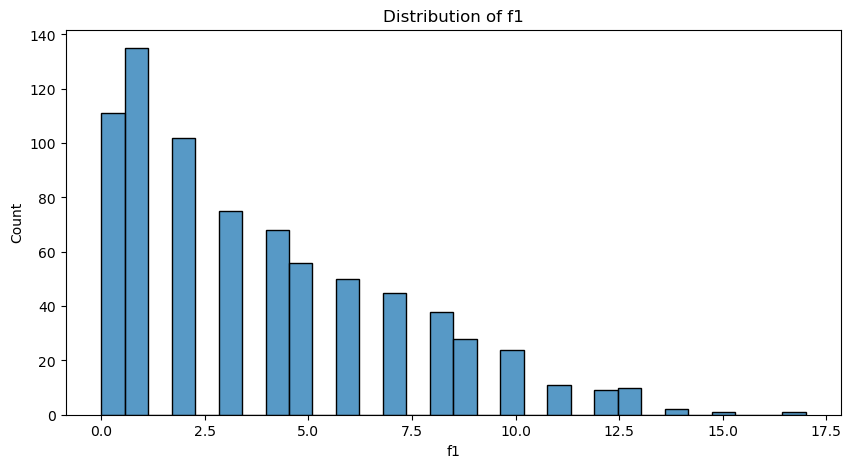

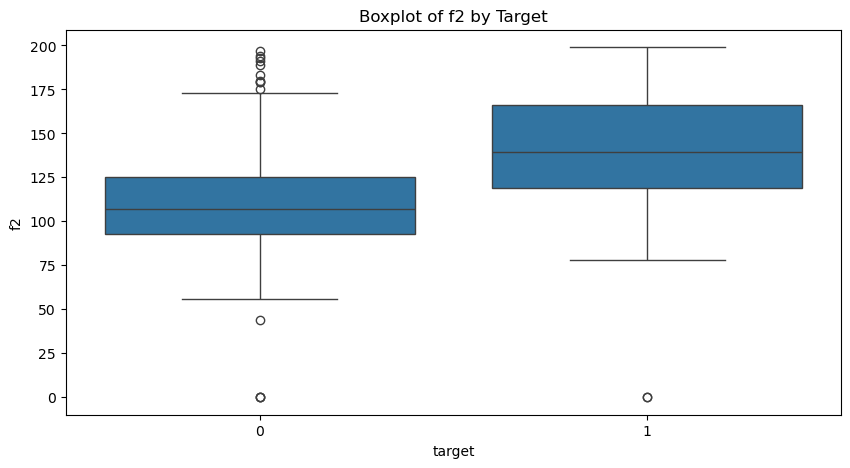

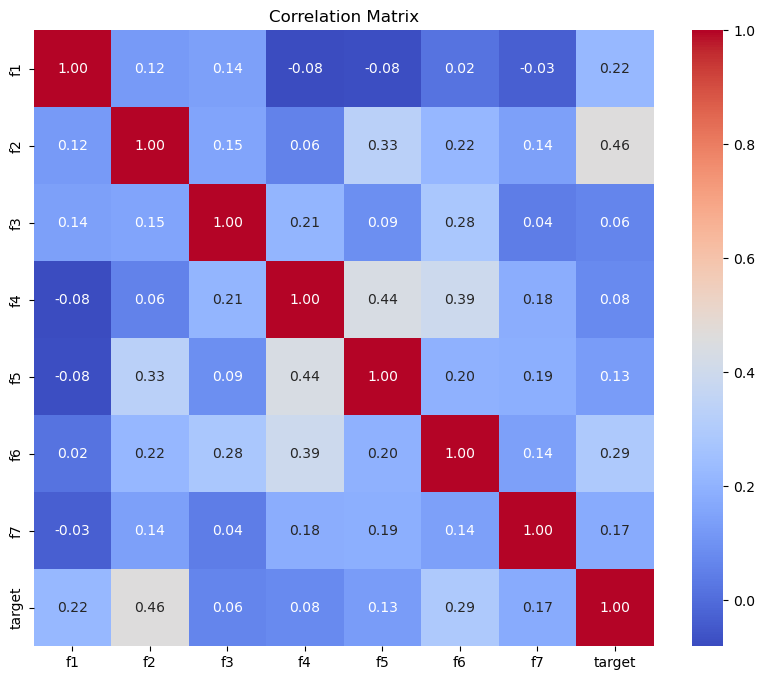

In [141]:
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['f1'], bins=30)
plt.title('Distribution of f1')
plt.show()

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='target', y='f2', data=df)
plt.title('Boxplot of f2 by Target')
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### Step 2: Preprocessing and Splitting the Dataset

#### Preprocessing

In [142]:
# Scaling numerical features
scaler = StandardScaler()
numerical_cols = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']  
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df.head()

,f1,f2,f3,f4,f5,f6,f7,target
0,0.639020,0.849692,0.148790,0.907715,-0.693970,0.203073,0.468461,1
1,-0.844281,-1.124238,-0.161060,0.531703,-0.693970,-0.684356,-0.364860,0
2,1.232341,1.946321,-0.264343,-1.285691,-0.693970,-1.102715,0.604328,1
3,-0.844281,-0.998909,-0.161060,0.155690,0.121578,-0.494193,-0.920407,0
4,-1.140941,0.505038,-1.503740,0.907715,0.763605,1.407440,5.483481,1


#### No categorical columns in the dataset hence conversion to numerical not required

#### Splitting the dataset

In [143]:
# Defining features and target
X = df.drop('target', axis=1)
y = df['target']

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.7, random_state=42)

print(X_train.count())
print(X_val.count())
print(X_test.count())

f1    429
f2    429
f3    429
f4    429
f5    429
f6    429
f7    429
dtype: int64
f1    183
f2    183
f3    183
f4    183
f5    183
f6    183
f7    183
dtype: int64
f1    154
f2    154
f3    154
f4    154
f5    154
f6    154
f7    154
dtype: int64


#### Converting the dataframe to Pytorch tensor

In [144]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

## Step 3: Defining the Neural Network

#### 1. Decide your NN architecture

<ol>
<li>Input Size - 7</li>
<li>Output size - 1</li>
<li>Activation function for hidden layers - ReLu</li>
<li>Activation function for output layer - Sigmoid for binary classification</li>
<li>Number of hidden layers - 2</li>
<li>Size of hidden layer - 64</li>
</ol>

#### 2. Defining the NN Architecture in PyTorch

In [145]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.sigmoid(self.fc3(x))
        return x


input_size = 7
hidden_size = 64
output_size = 1  
model = SimpleNN(input_size, hidden_size, output_size, dropout_prob=0.5)


#### 3. Returning the Summary of the Model

In [146]:
summary(model, input_size=(7, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNN                                 [7, 1]                    --
├─Linear: 1-1                            [7, 64]                   512
├─Dropout: 1-2                           [7, 64]                   --
├─Linear: 1-3                            [7, 64]                   4,160
├─Dropout: 1-4                           [7, 64]                   --
├─Linear: 1-5                            [7, 1]                    65
├─Sigmoid: 1-6                           [7, 1]                    --
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03

## Step 4: Training the Neural Network

#### Defining the loss function

In [147]:
loss_function = nn.BCELoss()

#### Choosing Optimizer and Learning Rate

In [148]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#### Setting Up the Training Loop and monitoring training and losses

In [149]:
epochs = 50

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

start_time = time.time()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train() 
    train_loss = 0
    correct_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad() 
        outputs = model(inputs)  
        loss = loss_function(outputs.squeeze(), labels)  
        loss.backward()  
        optimizer.step()  

        train_loss += loss.item() 

        pred_train = (outputs > 0.5).float()
        correct_train += (pred_train == labels).sum().item()

    avg_train_loss = train_loss / (len(X_train_tensor) / 32)
    train_losses.append(avg_train_loss)
    train_accuracies.append(correct_train / len(y_train_tensor))
    
    model.eval()
    epoch_val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = loss_function(val_outputs.squeeze(), val_labels).item()
            val_losses.append(val_loss)
            epoch_val_loss+=val_loss

            pred_val = (val_outputs > 0.5).float()
            correct_val += (pred_val == y_val_tensor).sum().item()
    
    val_accuracies.append(correct_val / len(y_val_tensor))
    
    print(f"Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")
print(f"Training completed in {time.time() - start_time:.2f} seconds.")

Epoch 1, Training Loss: 0.6200675538608006, Validation Loss: 0.11464174588521321
Epoch 2, Training Loss: 0.5336629769631794, Validation Loss: 0.12888823946317038
Epoch 3, Training Loss: 0.5405923404863903, Validation Loss: 0.12051938970883687
Epoch 4, Training Loss: 0.5407207523073468, Validation Loss: 0.10554759701093037
Epoch 5, Training Loss: 0.5112698525190353, Validation Loss: 0.11872056126594543
Epoch 6, Training Loss: 0.4825470043080194, Validation Loss: 0.11286122600237529
Epoch 7, Training Loss: 0.5247132011822292, Validation Loss: 0.1098716954390208
Epoch 8, Training Loss: 0.48950979326452526, Validation Loss: 0.11499667167663574
Epoch 9, Training Loss: 0.47518796580178396, Validation Loss: 0.1131515105565389
Epoch 10, Training Loss: 0.4828077639852251, Validation Loss: 0.11366642514864604
Epoch 11, Training Loss: 0.4797792136669159, Validation Loss: 0.10975869496663411
Epoch 12, Training Loss: 0.49954833728926523, Validation Loss: 0.10370709498723348
Epoch 13, Training Loss:

#### Saving the Best Model Weights

In [150]:
torch.save(model.state_dict(), 'datasets/model_weights.pth')

#### Performance of model on test data

In [151]:
model.eval()  
with torch.no_grad():
    test_outputs = model(torch.Tensor(X_test_tensor))

    test_loss = loss_function(test_outputs, y_test_tensor.unsqueeze(1))

    test_predictions = torch.round(test_outputs)  
    accuracy = accuracy_score(y_test_tensor, test_predictions)
    precision = precision_score(y_test_tensor, test_predictions)
    recall = recall_score(y_test_tensor, test_predictions)
    f1 = f1_score(y_test_tensor, test_predictions)

test_loss_value = test_loss.item()
test_accuracy_value = accuracy

test_losses = [test_loss_value] * epochs
test_accuracies = [test_accuracy_value*100] * epochs

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7467532467532467
Precision: 0.7058823529411765
Recall: 0.4528301886792453
F1 Score: 0.5517241379310345


#### Visualization

##### a. Training, Validation and Testing Accuracy

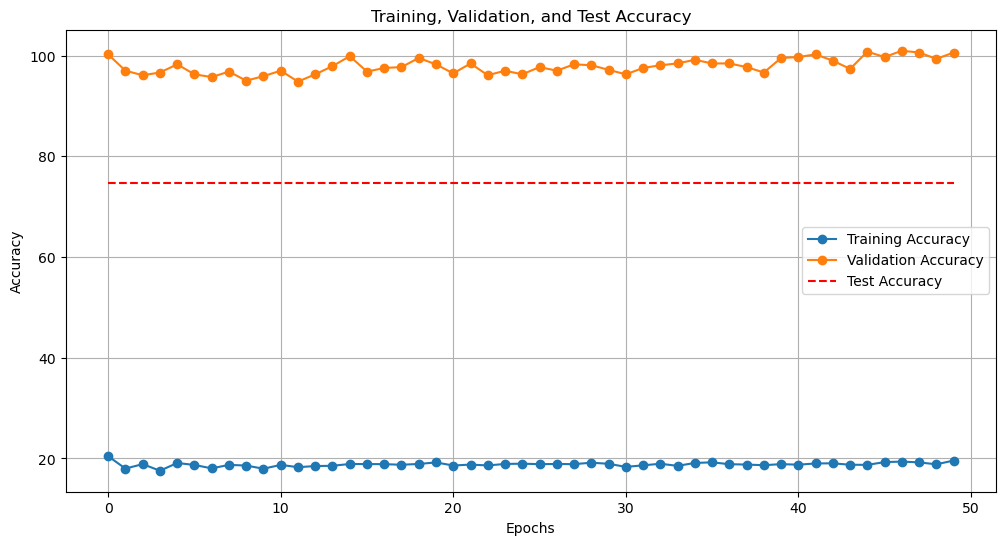

In [152]:
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

##### b. Training, Validation and Testing Losses

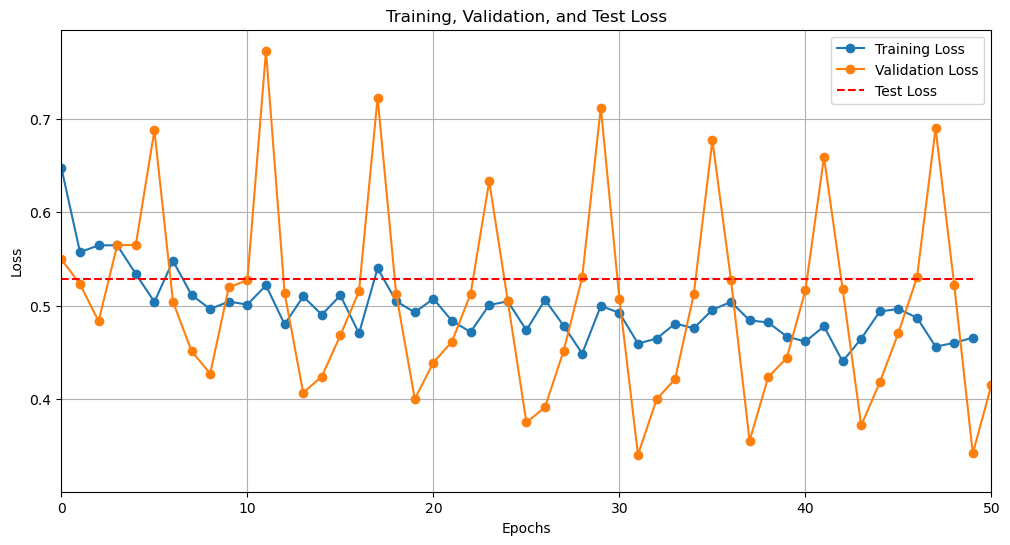

In [153]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.plot(test_losses, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.xlim(0,50)
plt.show()

#### c. Confusion Matrix

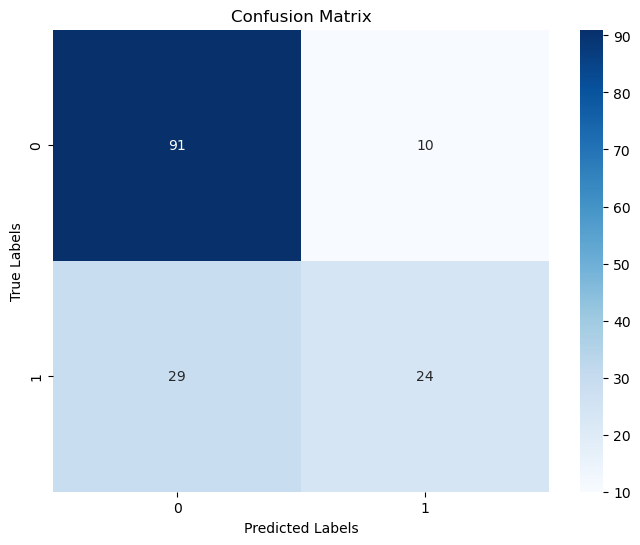

In [154]:
y_true = y_test_tensor.numpy() 
cm = confusion_matrix(y_true, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### d. ROC Curve

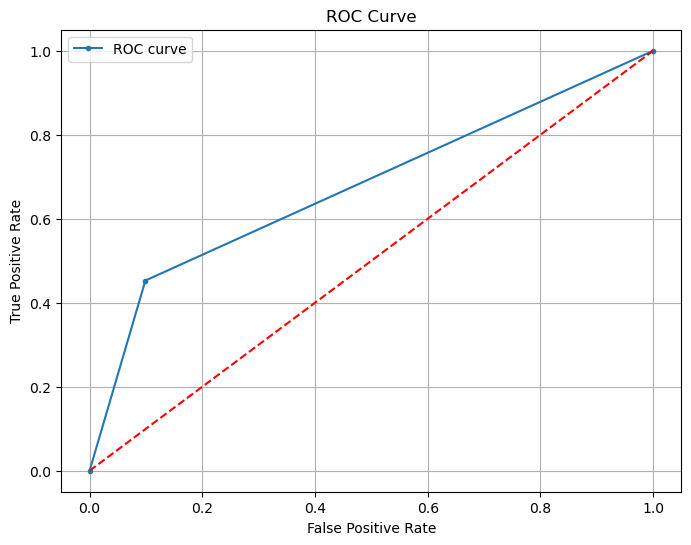

In [155]:
fpr, tpr, thresholds = roc_curve(y_true, test_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red') 
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

## Part II: Optimizing NN

### Changing Dropout rate

In [156]:
def train_and_evaluate_model(dropout_prob):
    model = SimpleNN(input_size, hidden_size, output_size, dropout_prob=dropout_prob)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 50
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pred_train = (outputs > 0.5).float()
            correct_train += (pred_train == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(correct_train / len(y_train_tensor))

        model.eval()
        with torch.no_grad():
            val_loss = 0
            correct_val = 0
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                loss = loss_function(val_outputs.squeeze(), val_labels).item()
                val_loss += loss
                pred_val = (val_outputs > 0.5).float()
                correct_val += (pred_val == val_labels).sum().item()
            
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(correct_val / len(y_val_tensor))
    
    # Testing the model
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_predictions = (test_outputs > 0.5).float()
        accuracy = accuracy_score(y_test_tensor, test_predictions)

    return accuracy

# Dropout Rate Tuning
dropout_rates = [0.1, 0.3, 0.5]
results = []

for rate in dropout_rates:
    accuracy = train_and_evaluate_model(rate)
    results.append({'Dropout Rate': rate, 'Test Accuracy': accuracy})

# Display Results
print("Dropout Rate Tuning Results:")
dropout_df = pd.DataFrame(results)
print(dropout_df)


Dropout Rate Tuning Results:
   Dropout Rate  Test Accuracy
0           0.1       0.707792
1           0.3       0.727273
2           0.5       0.766234


### Changing Learning rate

In [157]:
learning_rates = [0.001, 0.01, 0.1]
results_lr = []

for lr in learning_rates:
    model = SimpleNN(input_size, hidden_size, output_size, dropout_prob=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    accuracy = train_and_evaluate_model(0.5)  
    results_lr.append({'Learning Rate': lr, 'Test Accuracy': accuracy})

print("Learning Rate Tuning Results:")
lr_df = pd.DataFrame(results_lr)
print(lr_df)


Learning Rate Tuning Results:
   Learning Rate  Test Accuracy
0          0.001       0.746753
1          0.010       0.733766
2          0.100       0.753247


### Changing number of hidden layers

In [158]:
num_layers_options = [1, 2, 3]
results_layers = []

class DynamicNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob):
        super(DynamicNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, output_size))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.layers[:-1]: 
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.sigmoid(self.layers[-1](x))
        return x

for num_layers in num_layers_options:
    model = DynamicNN(input_size, hidden_size, output_size, num_layers, dropout_prob=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.10)  
    accuracy = train_and_evaluate_model(0.5) 
    results_layers.append({'Number of Layers': num_layers, 'Test Accuracy': accuracy})

print("Number of Hidden Layers Tuning Results:")
hidden_layer_df = pd.DataFrame(results_layers)
print(hidden_layer_df)


Number of Hidden Layers Tuning Results:
   Number of Layers  Test Accuracy
0                 1       0.772727
1                 2       0.753247
2                 3       0.740260


### Selecting the best model
#### From the above tuning steps we recognize following hyperparameters for best accuracy
##### Dropout Rate - 0.5
##### Learning Rate - 0.1
##### Number of hidden layers - 1